# Taylor integration example: $\dot x=x^2$

Here, we will integrate the initial-value problem (IVP) defined by

$$
\begin{align}
\dot x &= x^2 \\
x(0)&=x_0
\end{align}
$$

Given a real number $A>0$, the restriction of the function $f(x)=x^2$ over the interval $I_A=(-A,A)$ satisfies the Lipschitz condition $|f(x_1)-f(x_2)| \leq 2A|x_1-x_2|$ for every $x_1,x_2 \in I_A$. Therefore, the Picard-Lindelöf theorem for ordinary differential equations guarantees there exists a $\delta>0$ such that a solution for this IVP exists and is unique for $t \in [t_0,\delta)$, for any $x_0 \in I_A$. Note that in this case, it is necessary to restrict the function to a bounded interval in order to obtain a Lipschitz condition, which in turn is necessary to fulfill the conditions of the Picard-Lindelöf theorem.

Now, for any initial condition $x_0>0$, $t_0=0$ the analytical solution for this problem is:

$$
x(t)=\frac{x_0}{1-x_0\cdot t}
$$

In particular, the analytical solution exhibits a divergence at $t=1/x_0$; i.e., the solution is guaranteed to exist only for $t \in [0,1/x_0)$. How does a numerical integrator behave near this divergence?

We will try two methods to integrate this problem:

+ Adaptive time-step, 4th-order, Runge-Kutta (`ODE.jl`)
+ Taylor method (`TaylorIntegration.jl`)
+ Adaptive time-step, Runge-Kutta-Fehlberg 7/8 method (`ODE.jl`)

As an initial condition to integrate this IVP, we choose $x_0=3$, since this number is not exactly representable in a binary floating-point format. Thus, any constant time-step numerical integrator should break down when integrating up to $t_\mathrm{max}=1/3$.

We start off by including the relevant packages:

In [1]:
using TaylorIntegration, ODE, PyPlot

The ODE:

In [2]:
diffeq(t, x) = x.^2

diffeq (generic function with 1 method)

## 1. Adaptive time-step, 4th order, Runge Kutta method

We select $x_0=3$, $t_0=0$. Then, the singularity is at $t=1/3$.

In [3]:
@time tRK, xRK = ode45(diffeq, 3.0, [0.0, 0.34]); #warmup lap
@time tRK, xRK = ode45(diffeq, 3.0, [0.0, 0.34]);

  1.235191 seconds (1.71 M allocations: 77.339 MB, 1.86% gc time)
  0.000999 seconds (18.45 k allocations: 530.688 KB)


Plot $x$ vs $t$ (log-log):

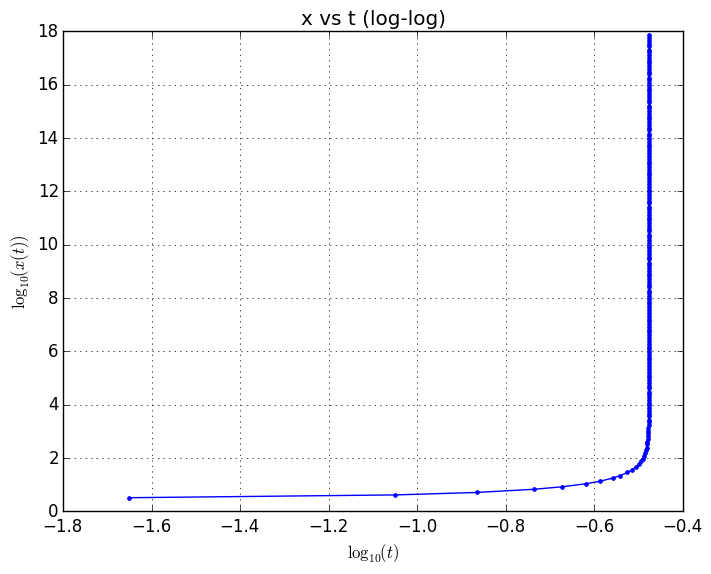

In [61]:
title("x vs t (log-log)")
xlabel(L"\log_{10}(t)")
ylabel(L"\log_{10}(x(t))")

grid(true)
plot(log10(tRK[2:end]), log10(xRK[2:end]), ".-");

What is the final state of the system?

In [5]:
tRK[end], xRK[end]

(0.33333423758781194,7.125446356124256e17)

Does the integrator get past the singularity?

In [6]:
tRK[end]>1/3

true

The answer is yes! So the last value of the solution is meaningless:

In [7]:
xRK[end] #this value is meaningless

7.125446356124256e17

How many steps did the RK integrator perform?

In [8]:
length(xRK)-1

166

How does the numerical solution compare to the analytical solution? The analytical solution is:

In [9]:
exactsol(t, x0) = x0./(1.0-x0.*t) #analytical solution

exactsol (generic function with 1 method)

The relative difference between the numerical and analytical solution, $\delta x$, is:

In [10]:
δxRK = (xRK-exactsol(tRK, 3.0))./exactsol(tRK, 3.0) #error relative to analytical solution
;

The $\delta x$ vs $t$ plot (semilog):

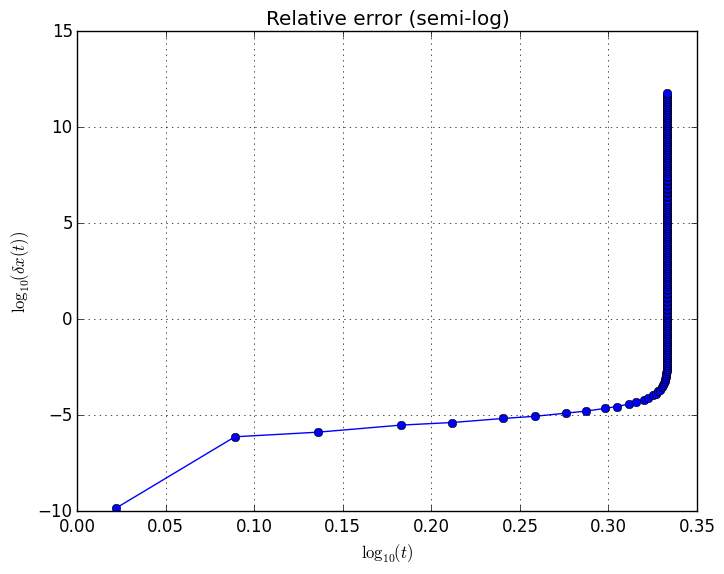

In [59]:
title("Relative error (semi-log)")
xlabel(L"\log_{10}(t)")
ylabel(L"\log_{10}(\delta x(t))")
grid(true)
plot(tRK, log10(abs(δxRK)), "o-");

This plot means that the error of the numerical solution grows systematically; and at the end of the integration, the error in the numerical solution is

In [12]:
(xRK[end-1]-exactsol(tRK[end-1], 3.0))

5.433622064235371e17

## 2. Taylor method

Again, we select $x_0=3$, $t_0=0$. The order of the Taylor integration is $28$, and we set the absolute tolerance equal to $10^{-20}$; this value is used during each time-step in order to compute an adaptive step size. We set the maximum number of integration steps equal to the number of steps that the previous integrator did.

In [13]:
@time tT, xT = taylorinteg(diffeq, 3.0, 0.0, 0.34, 28, 1e-20, maxsteps=length(xRK)-1); #warmup lap
@time tT, xT = taylorinteg(diffeq, 3.0, 0.0, 0.34, 28, 1e-20, maxsteps=length(xRK)-1);

  0.172252 seconds (186.71 k allocations: 9.235 MB)
  0.002670 seconds (37.91 k allocations: 2.348 MB)


In [14]:
tT[end], xT[end]

(0.3333333329479479,2.5948055925168757e9)

How many steps did the Taylor integrator perform?

In [15]:
length(xT)-1

166

Below, we show the $x$ vs $t$ plot (log-log):

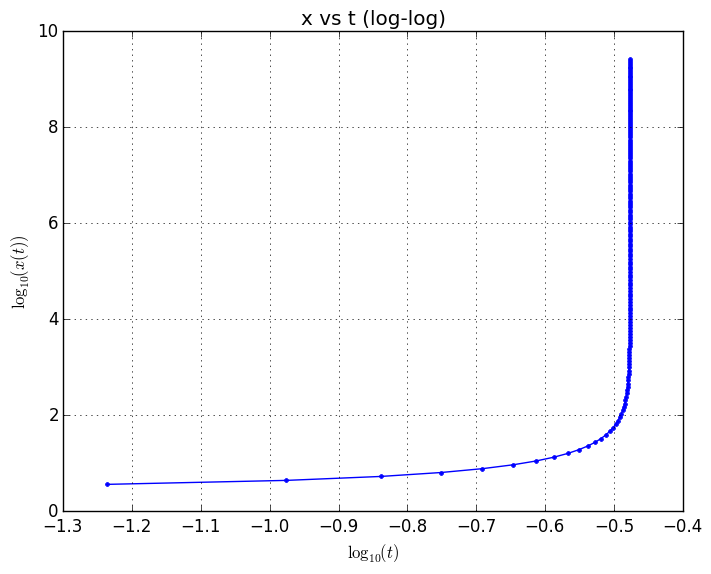

In [58]:
# axis([0, 0.35, -15, 10])
title("x vs t (log-log)")
xlabel(L"\log_{10}(t)")
ylabel(L"\log_{10}(x(t))")
grid(true)
plot(log10(tT[2:end]), log10(xT[2:end]), ".-");

Does the integrator get past the singularity?

In [17]:
tT[end] > 1/3

false

The answer is no! Even if increase the value of the `maxsteps` keyword in `taylorinteg`, it doesn't get past the singularity!

Now, the relative difference between the numerical and analytical solution, $\delta x$, is:

In [18]:
δxT = (xT.-exactsol(tT, 3.0))./exactsol(tT, 3.0);

The $\delta x$ vs $t$ plot (logscale):

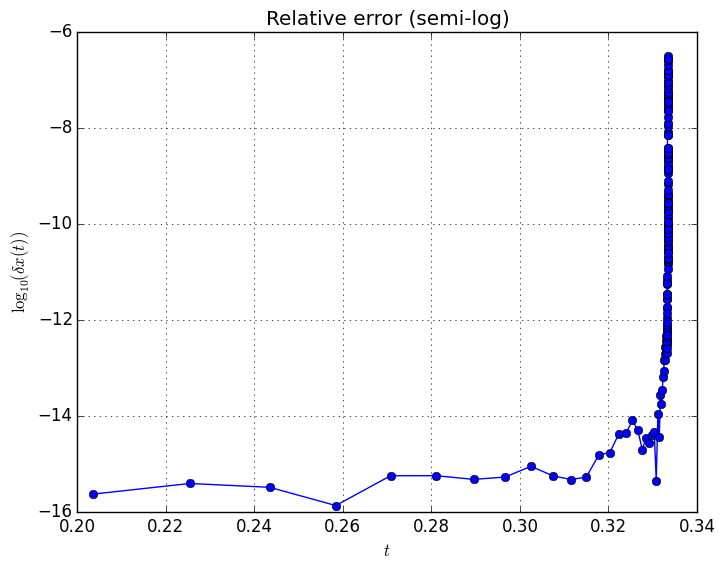

In [55]:
title("Relative error (semi-log)")
xlabel(L"t")
ylabel(L"\log_{10}(\delta x(t))")
grid(true)
plot(tT, log10(abs(δxT)), "o-");

We observe that, while the execution time is ~10 times longer wrt 4th-order RK, the numerical solution obtained by the Taylor integrator stays within $10^{-12}$ of the analytical solution, for a same number of steps.

Now, that happens if we use a higher order Runge Kutta method to integrate this problem?

## 3. Runge-Kutta-Fehlberg 7/8 method

Here we use the Runge-Kutta-Fehlberg 7/8 method, included in `ODE.jl`, to integrate the same problem as before.

In [20]:
@time t78, x78 = ode78(diffeq, 3.0, [0.0, 0.34]); #warmup lap
@time t78, x78 = ode78(diffeq, 3.0, [0.0, 0.34]);

  0.164455 seconds (150.73 k allocations: 6.613 MB, 4.77% gc time)
  0.000907 seconds (17.76 k allocations: 516.594 KB)


Plot $x$ vs $t$ (log-log):

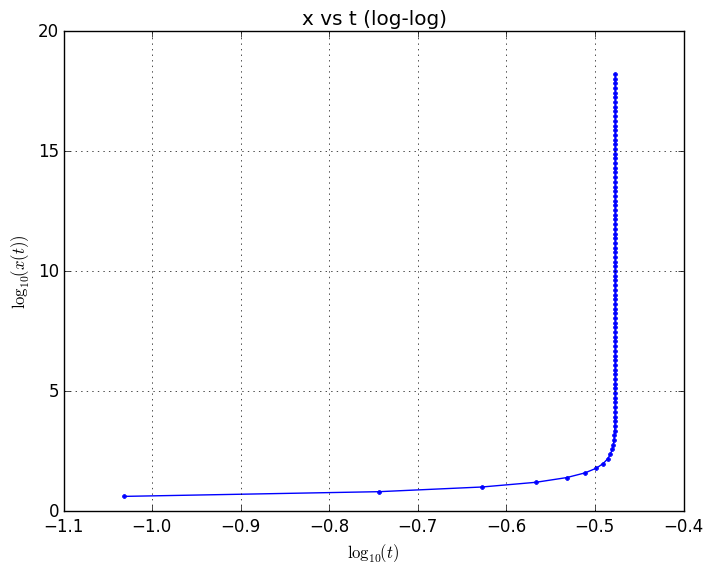

In [57]:
title("x vs t (log-log)")
xlabel(L"\log_{10}(t)")
ylabel(L"\log_{10}(x(t))")
grid(true)
plot(log10(t78[2:end]), log10(x78[2:end]), ".-");

What is the final state of the system?

In [22]:
t78[end], x78[end]

(0.3333336190078445,1.6711546943686948e18)

Does the integrator get past the singularity?

In [23]:
t78[end]>1/3

true

The answer is yes! So the last value of the solution is meaningless:

In [24]:
x78[end] #this value is meaningless

1.6711546943686948e18

How many steps did the RK integrator perform?

In [25]:
length(x78)-1

91

The relative difference between the numerical and analytical solution, $\delta x$, is:

In [26]:
δx78 = (x78-exactsol(t78, 3.0))./exactsol(t78, 3.0) #error relative to analytical solution
;

The $\delta x$ vs $t$ plot (semilog):

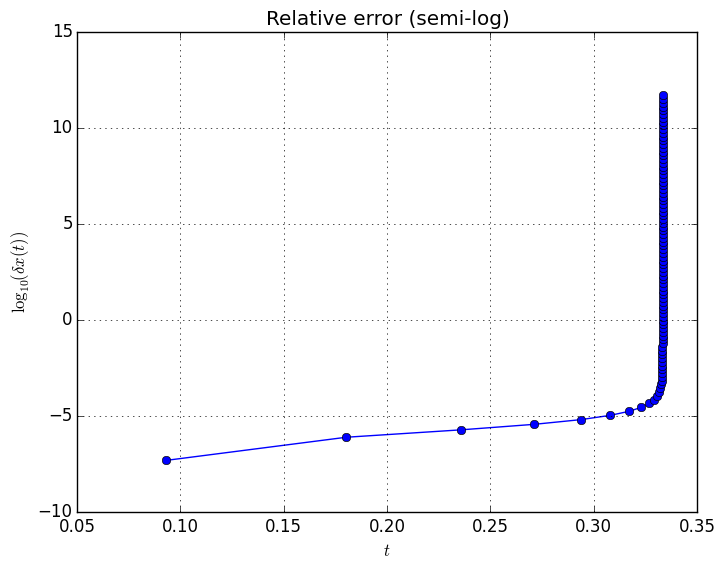

In [56]:
title("Relative error (semi-log)")
xlabel(L"t")
ylabel(L"\log_{10}(\delta x(t))")
grid(true)
plot(t78, log10(abs(δx78)), "o-");

This time, the RKF 7/8 integrator is "only" twice as fast as the Taylor integrator, but the error continues to be greater than the error from the latter by several orders of magnitude.

## 4. Adaptive 4th-order RK, stringer tolerance

As a last example, we will integrate once again our problem using a 4th-order adaptive RK integrator, but imposing a stringer tolerance:

In [29]:
#@time sol = solve(ODEProblem(diffeq, 3.0), [0.0,0.34], alg=:Feagin14) #warmup lap
#@time sol = solve(ODEProblem(diffeq, 3.0), [0.0,0.34], alg=:Feagin14)

In [30]:
#@time sol = solve(ODEProblem(diffeq, 3.0), [0.0,0.33333], alg=:DP5); #warmup lap
#@time sol = solve(ODEProblem(diffeq, 3.0), [0.0,0.34], alg=:DP5);

In [41]:
@time tRK_, xRK_ = ode45(diffeq, 3.0, [0.0, 0.34], abstol=1e-8, reltol=1e-8 ); #warmup lap
@time tRK_, xRK_ = ode45(diffeq, 3.0, [0.0, 0.34], abstol=1e-8, reltol=1e-8 ); #warmup lap
;

  0.027715 seconds (502.96 k allocations: 15.123 MB)
  0.031589 seconds (502.82 k allocations: 15.115 MB, 14.73% gc time)


Now, the integrator takes 10 times longer to complete the integration than the Taylor method.

Does it get past the singularity?

In [45]:
tRK_[end] > 1/3

true

Yes! So, once again, the last value reported by the integrator is completely meaningless. But, has it attained a higher precision than the Taylor method? Well, let's calculate once again the numerical error relative to the analytical solution:

In [46]:
δxo = (xo-exactsol(to, 3.0))./exactsol(to, 3.0);

And now, let's plot this relative error vs time:

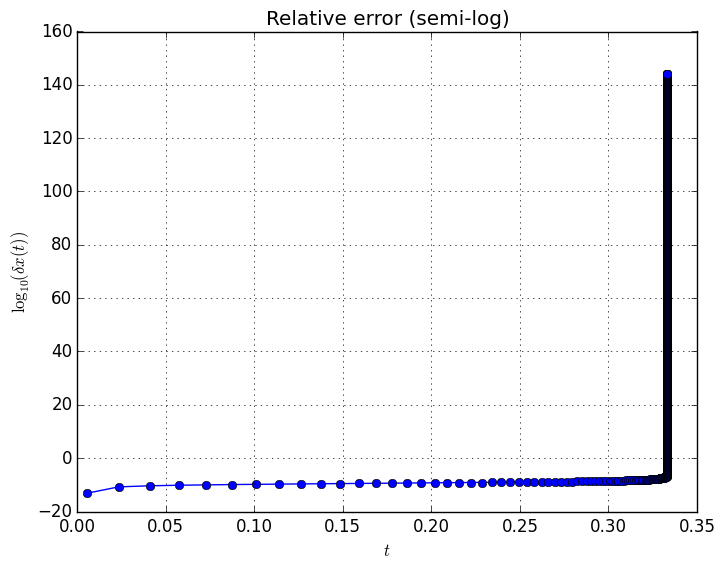

In [52]:
title("Relative error (semi-log)")
xlabel(L"t")
ylabel(L"\log_{10}(\delta x(t))")
grid(true)
plot(to, log10(abs(δxo)), "o-");

The numerical error has actually gotten worse! `TaylorIntegration.jl` is indeed a really competitive package to integrate ODEs.